This program takes in historical data and analyses the performance with respect to different technical indicators.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
# On balance volume
def analyse_OBV(data):
    OBV = [0]
    for i in range(1, len(data.Close)):
        if data.Close[i] > data.Close[i - 1]:
            OBV.append(OBV[-1] + data.Volume[i])
        elif data.Close[i] < data.Close[i - 1]:
            OBV.append(OBV[-1] - data.Volume[i])
        else:
            OBV.append(OBV[-1])
    return OBV

In [4]:
# Stochastic RSI
def analyse_stochRSI(data, period=14):
    delta = data.Close.diff(1)
    delta = delta.dropna()
    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    avgGain = up.ewm(span=period, adjust=False).mean()
    avgLoss = down.ewm(span=period, adjust=False).mean()
    rs = avgGain/avgLoss
    rsi = 100 - (100 / (1 + rs))
    stochRsi = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    return stochRsi

In [5]:
# Moving Average Convergence Divergence
def analyse_MACD(data, short_span=12, long_span=26):
    shortEma = data.Close.ewm(span=short_span, adjust=False).mean()
    longEma = data.Close.ewm(span=long_span, adjust=False).mean()
    macd = shortEma - longEma
    return macd

In [6]:
# Simple moving average
def sma(data, period=30):
    data.Close.rolling(period).mean()

In [7]:
# Exponential moving average
def ema(data, period=30):
    data.Close.ewm(window=period).mean()

In [8]:
def analyse_upper_lower_bollinger_bands(data, period=20):
    sma = data.Close.rolling(window=period).mean()
    sd = data.Close.rolling(window=period).std()
    upperBand = sma + (sd * 2)
    lowerBand = sma - (sd * 2)
    return (upperBand, lowerBand)

In [9]:
def analyse_ATR(data, period=20):
    high_low = data['High'] - data['Low']
    high_prevClose = np.abs(data['High'] - data['Close'].shift(1))
    low_prevClose = np.abs(data['Low'] - data['Close'].shift(1))
    tempdf = pd.concat([high_low, high_prevClose, low_prevClose], axis=1)
    tempdf.dropna(subset=[0, 1, 2], inplace=True)
    true_range = tempdf.max(axis=1)
    ATR = true_range.rolling(14).mean()
    return ATR

In [10]:
def analyse(filePath):
    df = pd.read_csv('BTC-USD.csv')
    df = df.set_index(pd.DatetimeIndex(df['Date'].values))
    df['OBV'] = analyse_OBV(df)
    df['RSI'] = analyse_stochRSI(df)
    df['MACD'] = analyse_MACD(df)
    df['ATR'] = analyse_ATR(df)
    bollinger_bands = analyse_upper_lower_bollinger_bands(df)
    df['Upper Bollinger Band'] = bollinger_bands[0]
    df['Lower Bollinger Band'] = bollinger_bands[1]
    return df

In [11]:
def execute_OBV_EMA(data, use_stop_loss=False):
    data['OBV_EMA'] = data['OBV'].ewm(span=20).mean()
    data['Trend'] = np.where(data.OBV > data.OBV_EMA,1 , 0)
    data['Signal'] = data['Trend'].diff()
    data['OBV_Buy_Price'] = np.where(df['Signal'] == 1, data['Close'], np.nan)
    data['OBV_Sell_Price'] = np.where(df['Signal'] == -1, data['Close'], np.nan)
    data.drop('Trend', axis=1, inplace=True)
    data.drop('Signal', axis=1, inplace=True)
    
    capital = 100
    holdQty = 0
    stopLoss = 0
    isHolding = False
    for i in range(len(data)):
        dayClose = data.Close[i]
        buyPrice = data.OBV_Buy_Price[i]
        sellPrice = data.OBV_Sell_Price[i]
        if(not isHolding and not np.isnan(buyPrice)):
            holdQty = capital / buyPrice
            isHolding = True
        elif(isHolding and not np.isnan(sellPrice)):
            capital = holdQty * sellPrice
            isHolding = False
        elif(use_stop_loss and dayClose < stopLoss):
            capital = holdQty * data.Close[i]
            isHolding = False
        else:
            continue
        stopLoss = dayClose - 7 * data.ATR[i]
    percentageChange = capital - 100
    return np.round(percentageChange, 3)
        

In [12]:
def execute_MACD(data, use_stop_loss=False):
    data['MACD_EMA'] = data.MACD.ewm(span=9, adjust=False).mean()
    data['Trend'] = np.where(data.MACD > data.MACD_EMA,1 , 0)
    data['Signal'] = data['Trend'].diff()
    data['MACD_Buy_Price'] = np.where(df['Signal'] == 1, data['Close'], np.nan)
    data['MACD_Sell_Price'] = np.where(df['Signal'] == -1, data['Close'], np.nan)
    data.drop('Trend', axis=1, inplace=True)
    data.drop('Signal', axis=1, inplace=True)
    
    capital = 100
    holdQty = 0
    stopLoss = 0
    isHolding = False
    for i in range(len(data)):
        buyPrice = data.MACD_Buy_Price[i]
        sellPrice = data.MACD_Sell_Price[i]
        dayClose = data.Close[i]
        if(not isHolding and not np.isnan(buyPrice)):
            holdQty = capital / buyPrice
            isHolding = True
        elif(isHolding and not np.isnan(sellPrice)):
            capital = holdQty * sellPrice
            isHolding = False
        elif(use_stop_loss and isHolding and dayClose < stopLoss):
            capital = holdQty * dayClose
            isHolding = False
        else:
            continue
        stopLoss = dayClose - data.ATR[i]
    percentageChange = capital - 100
    return np.round(percentageChange, 3)
    

In [13]:
df = analyse('BTC-USD.csv')
df = df.tail(365)

In [14]:
print(f'Percentage gain with stop loss(7 * ATR): {execute_OBV_EMA(df, use_stop_loss=True)}')

Percentage gain with stop loss(7 * ATR): 231.663


In [15]:
print(f'Percentage gain without stop loss: {execute_OBV_EMA(df, use_stop_loss=False)}')

Percentage gain without stop loss: 231.663


In [16]:
print(f'Percentage gain with stop loss(1 * ATR): {execute_MACD(df, use_stop_loss=True)}')

Percentage gain with stop loss(1 * ATR): 116.325


In [17]:
print(f'Percentage gain without stop loss: {execute_MACD(df, use_stop_loss=False)}')

Percentage gain without stop loss: 99.359


Through a series of trial and error:

The on Balance Volume trade strategy with stop loss of 7 times the Average True Range with produce the best outcome, however this performance is significantly impacted. A strategy without stoploss is produces 3x more returns.

The MACD Cross over trading strategy with a stop loss of 1 times the Average True Range provides higher returns.

An attempt to utilise the lower bollinger bands as stop loss did not yield improved returns.

In [18]:
df

,Date,Open,High,Low,Close,Volume,OBV,RSI,MACD,ATR,Upper Bollinger Band,Lower Bollinger Band,OBV_EMA,OBV_Buy_Price,OBV_Sell_Price,MACD_EMA,MACD_Buy_Price,MACD_Sell_Price
2020-12-09,2020-12-09,18320.884766,18626.292969,17935.546875,18553.916016,3.442037e+10,9.663333e+11,0.000000,726.387806,990.038226,20003.400167,17229.831083,9.663333e+11,NaN,NaN,726.387806,NaN,NaN
2020-12-10,2020-12-10,18553.298828,18553.298828,17957.064453,18264.992188,2.554713e+10,9.407862e+11,0.546886,637.850069,853.009766,19994.456887,17203.142136,9.529211e+11,NaN,NaN,708.680258,NaN,NaN
2020-12-11,2020-12-11,18263.929688,18268.453125,17619.533203,18058.904297,2.791964e+10,9.128665e+11,0.601216,544.773889,833.746931,19985.700270,17153.565942,9.382133e+11,NaN,NaN,675.898985,NaN,NaN
2020-12-12,2020-12-12,18051.320313,18919.550781,18046.041016,18803.656250,2.175258e+10,9.346191e+11,0.991425,525.053120,828.762835,20007.792617,17174.839024,9.371757e+11,NaN,NaN,645.729812,NaN,NaN
2020-12-13,2020-12-13,18806.765625,19381.535156,18734.332031,19142.382813,2.545047e+10,9.600696e+11,0.880295,530.639785,823.240792,20063.091611,17197.366202,9.427135e+11,19142.382813,NaN,622.711806,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-04,2021-12-04,53727.878906,53904.679688,42874.617188,49200.703125,6.138568e+10,1.215331e+12,1.000000,-1922.827523,3459.020926,63027.952651,51166.234459,1.304646e+12,NaN,NaN,-1329.550333,NaN,NaN
2021-12-05,2021-12-05,49201.519531,49768.148438,47857.496094,49368.847656,3.719820e+10,1.252529e+12,0.999542,-2274.975367,3496.532087,62457.401671,50317.883095,1.299683e+12,NaN,NaN,-1518.635340,NaN,NaN
2021-12-06,2021-12-06,49413.480469,50929.519531,47281.035156,50582.625000,3.770731e+10,1.290236e+12,0.994572,-2428.123486,3500.958147,62231.103237,49586.319420,1.298783e+12,NaN,NaN,-1700.532969,NaN,NaN
2021-12-07,2021-12-07,50581.828125,51934.781250,50175.808594,50700.085938,3.367681e+10,1.323913e+12,0.993846,-2511.070302,3466.402344,61790.367921,49060.262157,1.301177e+12,50700.085938,NaN,-1862.640436,NaN,NaN


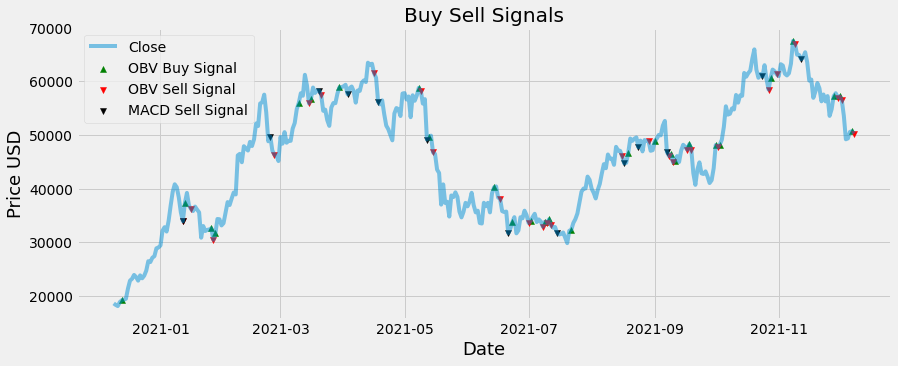

In [23]:
# View MACD and OBV signals
plt.figure(figsize=(13, 5))
plt.plot(df['Close'], label='Close', alpha=0.5)
plt.scatter(df.index, df['OBV_Buy_Price'], label='OBV Buy Signal', marker='^', color='green')
plt.scatter(df.index, df['OBV_Sell_Price'], label='OBV Sell Signal', marker='v', color='red')
# plt.scatter(df.index, df['MACD_Buy_Price'], label='MACD Buy Signal', marker='^', color='purple')
plt.scatter(df.index, df['MACD_Sell_Price'], label='MACD Sell Signal', marker='v', color='black')
plt.title('Buy Sell Signals')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD', fontsize=18)
plt.legend(loc='upper left')
plt.show()

Plot hints at MACD being a better sell signal than OBV

In [103]:
def execute_MACD_OBV(data, use_stop_loss=False):
    capital = 100
    holdQty = 0
    stopLoss = 0
    isHolding = False
    for i in range(len(data)):
        buyPrice = data.OBV_Buy_Price[i]
        sellPrice = data.MACD_Sell_Price[i]
        dayClose = data.Close[i]
        if(not isHolding and not np.isnan(buyPrice)):
            holdQty = capital / buyPrice
            isHolding = True
        elif(isHolding and not np.isnan(sellPrice)):
            capital = holdQty * sellPrice
            isHolding = False
        elif(use_stop_loss and isHolding and dayClose < stopLoss):
            capital = holdQty * dayClose
            isHolding = False
        else:
            continue
        stopLoss = dayClose - data.ATR[i]
    percentageChange = capital - 100
    return np.round(percentageChange, 3)

In [104]:
print(f'OBV to signal buy and MACD to signal sell with 1 ATR stop loss: {execute_MACD_OBV(df, use_stop_loss=True)}%')

OBV to signal buy and MACD to signal sell with 1 ATR stop loss: 570.307


In [105]:
print(f'OBV to signal buy and MACD to signal sell without stop loss: {execute_MACD_OBV(df, False)}%')

OBV to signal buy and MACD to signal sell without stop loss: 328.943


The performance of OBV and MACD with ATR although less than pure OBM, might be better suited for sideway or downtrend markets as it is more ready to close positions. A 570% return is almost similar to the buy and hold strategy.